### 1. Set-up

#### 1.1 Imports

In [45]:
# Imports
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import math
import time
import numpy as np
import sys
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
import math

#### 1.2 CUDA

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Data Pre-Processing

#### 2.1 Helper Functions

In [47]:
# Encoding and decoding
def decode(vocab,corpus):
    
    text = ''
    for i in range(len(corpus)):
        wID = corpus[i]
        text = text + vocab[wID] + ' '
    return(text)

def encode(words,text):
    corpus = []
    tokens = text.split(' ')
    for t in tokens:
        try:
            wID = words[t][0]
        except:
            wID = words['<unk>'][0]
        corpus.append(wID)
    return(corpus)

def read_encode(file_name,vocab,words,corpus,threshold):
    
    wID = len(vocab)
    
    if threshold > -1:
        with open(file_name,'rt', encoding='utf8') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]
            
                    
    with open(file_name,'rt', encoding='utf8') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)
                
    return [vocab,words,corpus]

def plot_data(x, y1, y2, xlabel, ylabel, title, color1, color2, label1, label2):
    plt.plot(x, y1, color1, label=label1)
    plt.plot(x, y2, color2, label=label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

#### 2.2 Create ngrams

In [48]:
def split_bios(data, words):
  fake_val, real_val = words["[FAKE]"][0], words["[REAL]"][0]
  fake_list = (data == fake_val)
  real_list = (data == real_val)
  target_indices = (fake_list + real_list).nonzero()
  bios_list = []
  start_i = 0

  for end_i in target_indices:
    bio = data[start_i:end_i+1]
    bios_list.append(bio)

    start_i = end_i + 1

  return bios_list

def clean_bios(bios, words):
  for bio_i in range(len(bios)):
    # Remove new lines and punctuation
    new_line_idx = words[''][0]
    comma_idx = words[','][0]
    period_idx = words['.'][0]
    colon_idx = words[':'][0]
    semicolon_idx = words[';'][0]

    punctuation_indices = [new_line_idx, comma_idx, period_idx, colon_idx, semicolon_idx]

    bios[bio_i] = list(filter(lambda x: x not in punctuation_indices, bios[bio_i]))

  return bios

########################################################################
def clean_data(data, words):
  new_line_idx = words[''][0]
  comma_idx = words[','][0]
  period_idx = words['.'][0]
  colon_idx = words[':'][0]
  semicolon_idx = words[';'][0]

  punctuation_indices = [new_line_idx, comma_idx, period_idx, colon_idx, semicolon_idx]

  data = list(filter(lambda x: x not in punctuation_indices, data))
  return data

def create_sequences(data, words, seq_len):
  seq_list = []
  pad_char_val = words['<unk>'][0]

  num_padding = (len(data) + 1) % seq_len
  if num_padding != 0:
    pad_array = [pad_char_val] * (len(data) - num_padding)
    data = data + pad_array

  i = 0
  while i < len(data) - seq_len:
    start, stop = i, i + seq_len
    inputs = torch.tensor(data[start:stop]).detach().to(device)
    outputs = torch.tensor(data[start+1:stop+1]).detach().to(device)

    seq = [inputs, outputs]
    seq_list.append(seq)

    i += seq_len

  return seq_list


#### 2.3 Data Loader

In [49]:
class NgramDataset(Dataset):
    def __init__(self, ngrams_data):
        self.ngrams_data_df = pd.DataFrame(ngrams_data, columns=("context", "label"))
        self.context = self.ngrams_data_df["context"]
        self.label = self.ngrams_data_df["label"]

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.context[idx], self.label[idx]

### 3. Model

In [50]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, vocab, words, d_model, d_hidden, n_layers, dropout_rate, seq_len):
        super().__init__()
        
        # Class Parameters
        self.vocab = vocab
        self.words = words
        self.vocab_size = len(self.vocab)
        self.n_layers = n_layers
        self.d_hidden = d_hidden
        self.d_model = d_model
        self.dropout = dropout_rate
        self.seq_len = seq_len

        # Embedding Layers
        self.input_embedding = nn.Embedding(self.vocab_size, self.d_model)

        # Linear Layer
        # self.fc1 = nn.Linear(seq_len * d_model, self.d_model)
        self.fc1 = nn.Linear(self.d_hidden, self.vocab_size)

        # LSTM Cell
        self.lstm = nn.LSTM(input_size=self.d_model, hidden_size=self.d_hidden, num_layers=self.n_layers, dropout=self.dropout)
        
    # Forward
    def forward(self, src, hc):
        embeds = self.input_embedding(src).view(self.seq_len, -1, self.d_model)
        # embeds = self.input_embedding(src).view(-1, self.batch_size, self.d_model * self.seq_len)
        # x = self.fc1(embeds)
        # preds, hc = self.lstm(x, hc)
        preds, hc = self.lstm(embeds, hc)
        preds = preds.view(-1, self.d_hidden)
        logits = self.fc1(preds).view(-1, self.vocab_size)
        return [logits, hc]
    
    def init_weights(self):
        weight_range = 0.1
        
        self.input_embedding.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.weight.data.uniform_(-weight_range, weight_range)
        self.fc1.bias.data.zero_()
    
    def detach_hidden(self, hc):
        (hidden, cell) = hc
        hidden = hidden.detach()
        cell = cell.detach()
        return [hidden, cell]

### 4. Train

#### 4.1 Metrics

#### 4.2 Train One Epoch

In [51]:
def lstm_train_one_epoch(model, optimizer, criterion, train_dataloader, valid_dataloader, batch_size, clip):

  # Training Set
  running_train_acc, running_train_loss = 0, 0
  train_num_batches = len(train_dataloader)
  
  hc = (torch.randn(model.n_layers, batch_size, model.d_hidden).to(device),
        torch.randn(model.n_layers, batch_size, model.d_hidden).to(device))

  for batch_idx, (train_inputs, train_outputs) in enumerate(train_dataloader):
    model.zero_grad()
    hc = model.detach_hidden(hc)

    train_logits, hc = model(train_inputs, hc)
    train_logits = train_logits.reshape(-1, model.vocab_size)
    train_outputs = train_outputs.reshape(-1)
    train_preds = torch.argmax(train_logits, dim=1)
    train_loss = criterion(train_logits, train_outputs)
    train_acc = accuracy_score(np.array(train_outputs.cpu()), np.array(train_preds.cpu()))

    running_train_loss += train_loss.item()
    running_train_acc += train_acc

    # if batch_idx % 1000 == 0: 
    #     print(f"Train Batch: {batch_idx+1}")
    #     print(f"Train Loss: {running_train_loss / (batch_idx+1)}")
    #     print(f"Train Accuracy: {running_train_acc / (batch_idx+1)}\n")

    train_loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  train_av_acc = running_train_acc / train_num_batches
  train_av_loss = running_train_loss / train_num_batches


  # Valid Set
  hc = (torch.randn(model.n_layers, batch_size, model.d_hidden).to(device),
        torch.randn(model.n_layers, batch_size, model.d_hidden).to(device))

  running_valid_acc, running_valid_loss = 0, 0
  valid_num_batches = len(valid_dataloader)
  for batch_idx, (valid_inputs, valid_outputs) in enumerate(valid_dataloader):
    hc = model.detach_hidden(hc)

    valid_logits, hc = model(valid_inputs, hc)
    valid_logits = valid_logits.reshape(-1, model.vocab_size)
    valid_outputs = valid_outputs.reshape(-1)
    valid_preds = torch.argmax(valid_logits, dim=1)
    valid_loss = criterion(valid_logits, valid_outputs)
    valid_acc = accuracy_score(np.array(valid_outputs.cpu()), np.array(valid_preds.cpu()))

    running_valid_loss += valid_loss.item()
    running_valid_acc += valid_acc

    # if batch_idx % 1000 == 0: 
    #     print(f"Valid Batch: {batch_idx+1}")
    #     print(f"Valid Loss: {running_valid_loss / (batch_idx+1)}")
    #     print(f"Valid Accuracy: {running_valid_acc / (batch_idx+1)}\n")

  valid_av_acc = running_valid_acc / valid_num_batches
  valid_av_loss = running_valid_loss / valid_num_batches

  return train_av_acc, train_av_loss, valid_av_acc, valid_av_loss



#### 4.3 Train Multiple Epochs

In [52]:
def lstm_train_loop(model, optimizer, criterion, train_dataloader, valid_dataloader, batch_size, clip, epochs):
  train_accuracies = []
  train_losses = []
  train_perplexities = []
  valid_accuracies = []
  valid_losses = []
  valid_perplexities = []
  epochs_list = list(range(epochs))

  for i in epochs_list:
    print(f"Epoch: {i+1} /////////////////////////////////////")
    model.train(True)
    train_av_acc, train_av_loss, valid_av_acc, valid_av_loss = lstm_train_one_epoch(model, optimizer, criterion, train_dataloader, valid_dataloader, batch_size, clip)
    model.train(False)

    train_perplexity = math.exp(train_av_loss)
    valid_perplexity = math.exp(valid_av_loss)

    print(f"Accuracy: {train_av_acc}")
    print(f"Loss: {train_av_loss}")
    print(f"Perplexity: {train_perplexity}\n")

    train_accuracies.append(train_av_acc)
    train_losses.append(train_av_loss)
    train_perplexities.append(train_perplexity)
    valid_accuracies.append(valid_av_acc)
    valid_losses.append(valid_av_loss)
    valid_perplexities.append(valid_perplexity)

  # Graph Accuracies and Loss
  plot_data(x=epochs_list, y1=train_accuracies, y2=valid_accuracies, xlabel="Epochs", ylabel="Accuracy", title="Accuracy", color1='b', color2='r', label1='Train', label2='Valid')
  plot_data(x=epochs_list, y1=train_losses, y2=valid_losses, xlabel="Epochs", ylabel="Loss", title="Loss", color1='b', color2='r', label1='Train', label2='Valid')
  plot_data(x=epochs_list, y1=train_perplexities, y2=valid_perplexities, xlabel="Epochs", ylabel="Perplexity", title="Perplexity", color1='b', color2='r', label1='Train', label2='Valid')


### 5. Validation

### 6. Test

### 7. Running Code


#### 7.1 Loading Parameters

In [53]:
class Params:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
            
model_map = {0: 'FFNN', 1: 'LSTM', 2: 'FFNN_CLASSIFY', 3: 'LSTM_CLASSIFY'}
train_map = {0: 'data/real.train.tok', 1: 'data/fake.train.tok', 2: 'data/mix.train.tok'}
valid_map = {0: 'data/real.valid.tok', 1: 'data/fake.valid.tok', 2: 'data/mix.valid.tok'}
test_map = {0: 'data/real.test.tok', 1: 'data/fake.test.tok', 2: 'data/mix.test.tok', 3: 'data/blind.test.tok'}

model_type = model_map[1]

# Types of data
train_type = train_map[2]
valid_type = valid_map[2]
test_type = test_map[2]

args = {
    "d_model": 512,
    "d_hidden": 512,
    "n_layers": 1,
    "batch_size": 64,
    "seq_len": 30,
    "printevery": 5000,
    "window": 3,
    "epochs": 30,
    "lr": 0.0001,
    "dropout": 0.35,
    "clip": 2.0,
    "model": model_type,
    "savename": model_type.lower(),
    "loadname": model_type.lower(),
    "trainname": train_type,
    "validname": valid_type,
    "testname": test_type
}

#### 7.2 Main

In [54]:
# Main Function
def main(args): 
    torch.manual_seed(0)
    
    # params
    params = Params(**args)
    train_name = params.trainname
    valid_name = params.validname
    test_name = params.testname
    model_type = params.model
    d_model = params.d_model
    d_hidden = params.d_hidden
    dropout = params.dropout
    epochs = params.epochs
    window = params.window
    seq_len = params.seq_len
    batch_size = params.batch_size
    lr = params.lr
    n_layers = params.n_layers
    clip = params.clip


    # Extract vocab and words
    [train_vocab,train_words,train] = read_encode(train_name,[],{},[],3)
    train_data = torch.tensor(train)

    [valid_vocab,valid_words,valid] = read_encode(valid_name,[],{},[],3)
    valid_data = torch.tensor(valid)

    [test_vocab,test_words,test] = read_encode(test_name,[],{},[],3)
    test_data = torch.tensor(test)

    
    if model_type == 'FFNN':
      # Process Train Data
      train_bios = split_bios(train_data, train_words)
      train_bios = clean_bios(train_bios, train_words)
      train_ngrams_data = create_ngrams(train_bios, train_words, window)

      train_ngram_dataset = NgramDataset(train_ngrams_data)
      train_ngram_dataloader = DataLoader(train_ngram_dataset, batch_size=batch_size, shuffle=True)

      # Process Valid Data
      valid_bios = split_bios(valid_data, valid_words)
      valid_bios = clean_bios(valid_bios, valid_words)
      valid_ngrams_data = create_ngrams(valid_bios, valid_words, window)

      valid_ngram_dataset = NgramDataset(valid_ngrams_data)
      valid_ngram_dataloader = DataLoader(valid_ngram_dataset, batch_size=batch_size, shuffle=True)

      # Create and Train FFNN Model
      ngram_model = FFNN(train_vocab, train_words, d_model, d_hidden, dropout, window).to(device)
      optimizer = torch.optim.Adam(ngram_model.parameters(), lr=lr)
      criterion = nn.CrossEntropyLoss()

      train_loop(ngram_model, optimizer, criterion, train_ngram_dataloader, valid_ngram_dataloader, epochs)

      torch.save(ngram_model.state_dict(), 'ffnn.pth')


    if model_type == 'LSTM':
      # Process Train Data
      clean_train_data = clean_data(train_data, train_words)
      train_sequences = create_sequences(clean_train_data, train_words, seq_len)
      train_lstm_dataset = NgramDataset(train_sequences)
      train_lstm_dataloader = DataLoader(train_lstm_dataset, batch_size=batch_size, drop_last=True)

      # Process Valid Data
      clean_valid_data = clean_data(valid_data, valid_words)
      valid_sequences = create_sequences(clean_valid_data, valid_words, seq_len)
      valid_lstm_dataset = NgramDataset(valid_sequences)
      valid_lstm_dataloader = DataLoader(valid_lstm_dataset, batch_size=batch_size, drop_last=True)

      # Create and Train LSTM Model
      lstm_model = LSTM(train_vocab, train_words, d_model, d_hidden, n_layers, dropout, seq_len).to(device)
      optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
      criterion = nn.CrossEntropyLoss()

      # lstm_train_one_epoch(lstm_model, optimizer, criterion, train_lstm_dataloader, valid_lstm_dataloader, batch_size, clip)
      lstm_train_loop(lstm_model, optimizer, criterion, train_lstm_dataloader, valid_lstm_dataloader, batch_size, clip, epochs)

      torch.save(lstm_model.state_dict(), 'lstm.pth')

    if model_type == 'FFNN_CLASSIFY':
        pass
    if model_type == 'LSTM_CLASSIFY':
        pass


2742
Epoch: 1 /////////////////////////////////////
Train Batch: 1
Train Loss: 10.513253211975098
Train Accuracy: 0.0



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Train Batch: 1001
Train Loss: 10.36211656976294
Train Accuracy: 0.0013772685647685642

Train Batch: 2001
Train Loss: 9.43150334522642
Train Accuracy: 0.002156734132933532

Valid Batch: 1
Valid Loss: 9.688337326049805
Valid Accuracy: 0.06041666666666667

Accuracy: 0.2648853482859227
Loss: 8.648518526319341
Perplexity: 5701.69356477449

Epoch: 2 /////////////////////////////////////
Train Batch: 1
Train Loss: 9.168209075927734
Train Accuracy: 0.06510416666666667

Train Batch: 1001
Train Loss: 8.393913828766905
Train Accuracy: 0.03250291375291374

Train Batch: 2001
Train Loss: 7.256399381047544
Train Accuracy: 0.14892944152923537

Valid Batch: 1
Valid Loss: 8.710926055908203
Valid Accuracy: 0.0703125

Accuracy: 0.37892334518599563
Loss: 6.419105438747865
Perplexity: 613.454096332599

Epoch: 3 /////////////////////////////////////
Train Batch: 1
Train Loss: 7.747134685516357
Train Accuracy: 0.06822916666666666

Train Batch: 1001
Train Loss: 7.369341903633171
Train Accuracy: 0.0427582833832

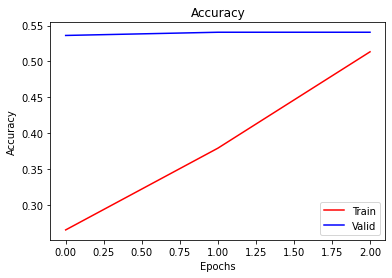

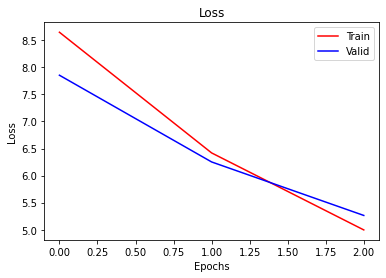

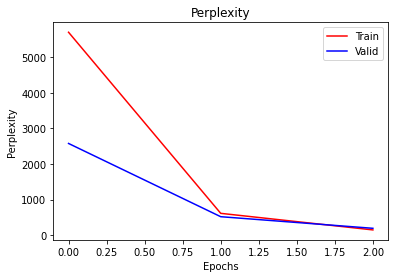

In [55]:
main(args)